# Example 2: 1st-level Analysis

In this example, we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

## Imports

First, we need to import all the modules we later want to use.

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


211107-08:23:52,994 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [13]:
experiment_dir = '/home/neuro/Result/Nipype_tutorial/working_dir'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# TR of functional images
with open('/home/neuro/Data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

stty: 'standard input': Inappropriate ioctl for device


## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [4]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

## Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [5]:
!cat /home/neuro/Data/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


We can also create a data frame using pandas library.

In [6]:
import pandas as pd
trialinfo = pd.read_table('/home/neuro/Data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


And finally we need to separate the onsets of the three conditions, i.e. group by ``trial_type``. This can be done as follows:

In [7]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)

('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)

('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)



Now, let us incorporate all this in the helper function ``subjectinfo``.

In [12]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/home/neuro/Data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [14]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_ses-test_task-{task_id}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}', 
                             'art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [15]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

211107-10:11:14,884 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/graph.png (graph2use=flat, simple_form=True).


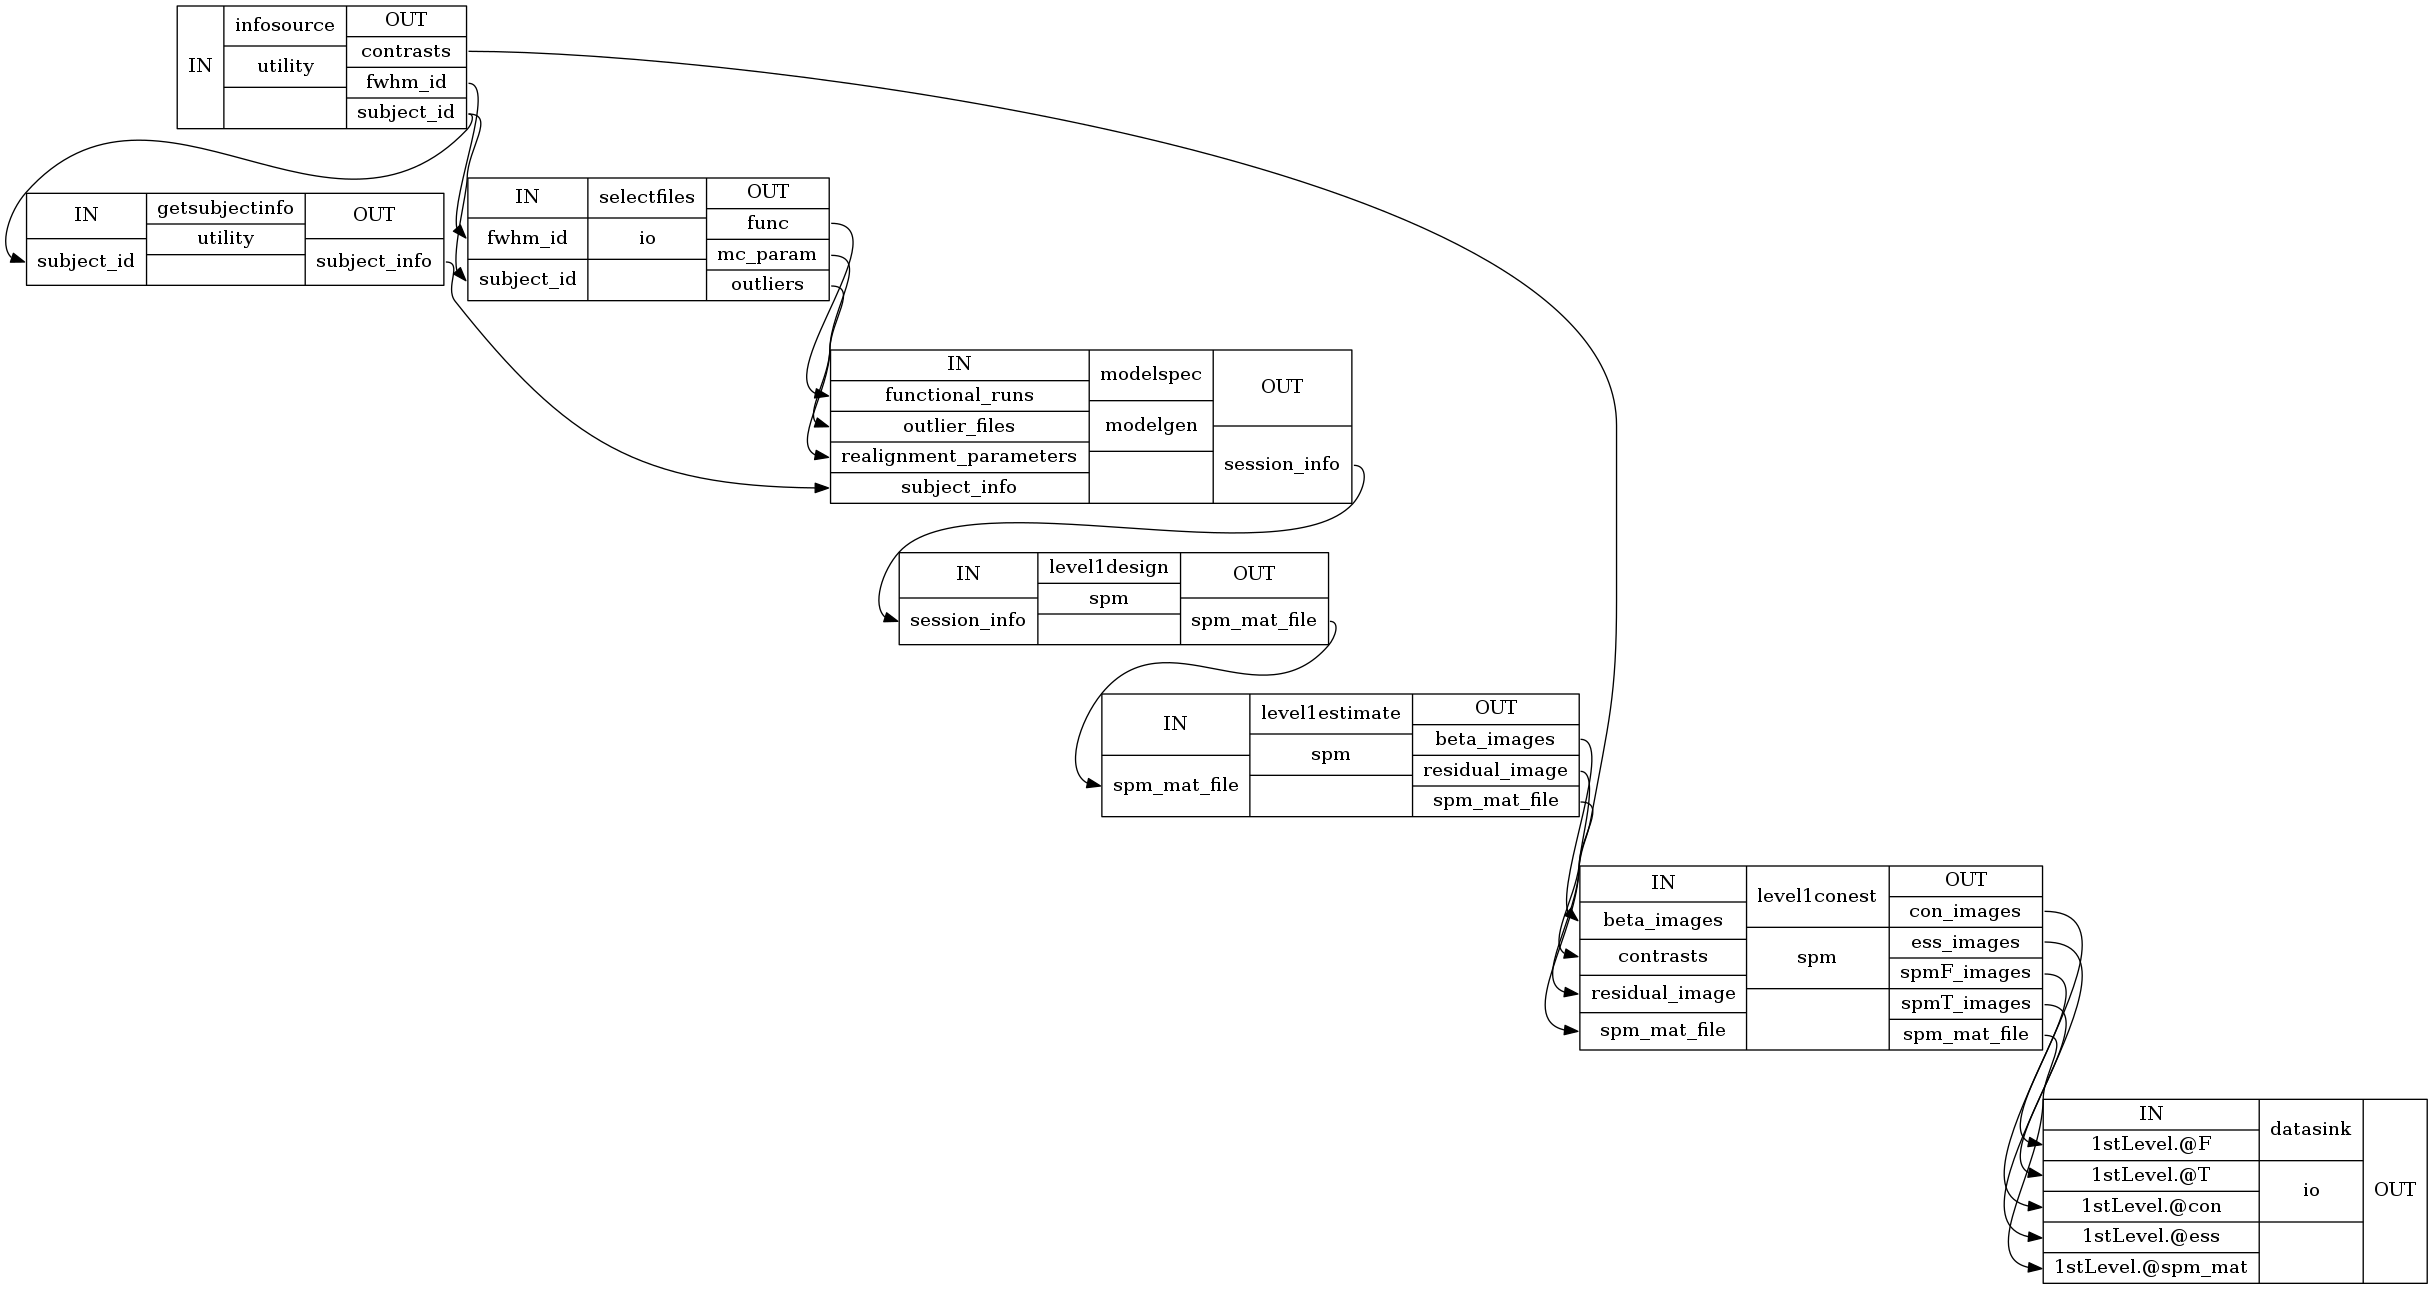

In [18]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph_detailed.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [19]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

211107-10:23:23,883 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
211107-10:23:24,164 nipype.workflow INFO:
	 Running in parallel.
211107-10:23:24,167 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 40 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-10:23:24,251 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_10/getsubjectinfo".
211107-10:23:24,253 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_10/selectfiles".
211107-10:23:24,254 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_10/getsubjectinfo".
211107-10:23:24,256 nipype.workflow INFO:
	 [Node] Setting-up

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-10:23:38,179 nipype.workflow INFO:
	 [Job 3] Completed (l1analysis.level1design).
211107-10:23:38,180 nipype.workflow INFO:
	 [Job 10] Completed (l1analysis.level1design).
211107-10:23:38,182 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:23:38,245 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_10/level1estimate".
211107-10:23:38,246 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_10/level1estimate".
211107-10:23:38,402 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-1

stty: 'standard input': Inappropriate ioctl for device


211107-10:23:40,181 nipype.workflow INFO:
	 [Job 17] Completed (l1analysis.level1design).
211107-10:23:40,183 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 33 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
211107-10:23:40,240 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_09/level1estimate".
211107-10:23:40,363 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:23:42,182 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
               

stty: 'standard input': Inappropriate ioctl for device


211107-10:23:44,183 nipype.workflow INFO:
	 [Job 24] Completed (l1analysis.level1design).
211107-10:23:44,185 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 33 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:23:44,244 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_09/level1estimate".
211107-10:23:44,367 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:23:46,186 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
             

stty: 'standard input': Inappropriate ioctl for device


211107-10:23:54,711 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:23:56,192 nipype.workflow INFO:
	 [Job 4] Completed (l1analysis.level1estimate).
211107-10:23:56,193 nipype.workflow INFO:
	 [Job 11] Completed (l1analysis.level1estimate).
211107-10:23:56,195 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:23:56,255 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_10/level1conest".
211107-10:23:56,257 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_10/level1conest".
211107-10:23:56,490 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-

stty: 'standard input': Inappropriate ioctl for device


211107-10:23:58,193 nipype.workflow INFO:
	 [Job 18] Completed (l1analysis.level1estimate).
211107-10:23:58,195 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 33 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:23:58,263 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_09/level1conest".
211107-10:23:58,483 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:00,195 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                    

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:02,197 nipype.workflow INFO:
	 [Job 25] Completed (l1analysis.level1estimate).
211107-10:24:02,199 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 33 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:24:02,263 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_09/level1conest".
211107-10:24:02,478 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:04,199 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                      

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:05,281 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:06,200 nipype.workflow INFO:
	 [Job 5] Completed (l1analysis.level1conest).
211107-10:24:06,202 nipype.workflow INFO:
	 [Job 12] Completed (l1analysis.level1conest).
211107-10:24:06,204 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 34 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:24:06,258 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_10/datasink".
211107-10:24:06,260 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_10/datasink".
211107-10:24:06,295 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:24:06,297 nipype.interface INFO:
	 sub: 

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:08,202 nipype.workflow INFO:
	 [Job 19] Completed (l1analysis.level1conest).
211107-10:24:08,203 nipype.workflow INFO:
	 [Job 6] Completed (l1analysis.datasink).
211107-10:24:08,204 nipype.workflow INFO:
	 [Job 13] Completed (l1analysis.datasink).
211107-10:24:08,206 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 33 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:24:08,264 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_09/datasink".
211107-10:24:08,264 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/getsubjectinfo".
211107-10:24:08,266 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/Result

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:10,421 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211107-10:24:10,424 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:12,209 nipype.workflow INFO:
	 [Job 26] Completed (l1analysis.level1conest).
211107-10:24:12,214 nipype.workflow INFO:
	 [Job 30] Completed (l1analysis.modelspec).
211107-10:24:12,219 nipype.workflow INFO:
	 [Job 35] Completed (l1analysis.getsubjectinfo).
211107-10:24:12,222 nipype.workflow INFO:
	 [Job 36] Completed (l1analysis.selectfiles).
211107-10:24:12,224 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 31 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-10:24:12,280 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_09/datasink".
211107-10:24:12,281 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/level1design".
211107-10:24:12,282 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Resu

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:12,391 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmT_0005.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-09/fwhm-4/spmT_0005.nii
211107-10:24:12,401 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmT_0006.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-09/fwhm-4/spmT_0006.nii
211107-10:24:12,411 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmT_0007.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-09/fwhm-4/spmT_0007.nii
211107-10:24:12,419 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_09/spmF_0008.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-09/fwhm-4/spmF_0008.nii


/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:16,381 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211107-10:24:18,212 nipype.workflow INFO:
	 [Job 44] Completed (l1analysis.modelspec).
211107-10:24:18,213 nipype.workflow INFO:
	 [Job 50] Completed (l1analysis.selectfiles).
211107-10:24:18,215 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 26 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:24:18,278 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_07/level1design".
211107-10:24:18,279 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/modelspec".
211107-10:24:18,335 nipype.workflow INFO:
	 [Node] Running "lev

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:18,400 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
211107-10:24:20,212 nipype.workflow INFO:
	 [Job 51] Completed (l1analysis.modelspec).
211107-10:24:20,214 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:24:20,269 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/level1design".
211107-10:24:20,328 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211107-10:24:20,419 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:22,214 nipype.workflow INFO:
	 [Job 31] Completed (l1analysis.level1design).
211107-10:24:22,216 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:24:22,279 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/level1estimate".
211107-10:24:22,394 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:24:22,585 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:24,216 nipype.workflow INFO:
	 [Job 38] Completed (l1analysis.level1design).
211107-10:24:24,218 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:24:24,294 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_08/level1estimate".
211107-10:24:24,442 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:24:26,217 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                 

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:28,217 nipype.workflow INFO:
	 [Job 45] Completed (l1analysis.level1design).
211107-10:24:28,219 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
211107-10:24:28,283 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_07/level1estimate".
211107-10:24:28,407 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:24:28,850 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:30,219 nipype.workflow INFO:
	 [Job 52] Completed (l1analysis.level1design).
211107-10:24:30,221 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:24:30,282 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/level1estimate".
211107-10:24:30,401 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:24:32,221 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
             

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:38,224 nipype.workflow INFO:
	 [Job 32] Completed (l1analysis.level1estimate).
211107-10:24:38,226 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:24:38,282 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/level1conest".
211107-10:24:38,595 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:39,920 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:40,224 nipype.workflow INFO:
	 [Job 39] Completed (l1analysis.level1estimate).
211107-10:24:40,226 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:24:40,285 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_08/level1conest".
211107-10:24:40,521 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:42,227 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                  

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:44,227 nipype.workflow INFO:
	 [Job 46] Completed (l1analysis.level1estimate).
211107-10:24:44,229 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:24:44,293 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_07/level1conest".
211107-10:24:44,539 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:45,248 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:46,228 nipype.workflow INFO:
	 [Job 53] Completed (l1analysis.level1estimate).
211107-10:24:46,230 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:24:46,291 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/level1conest".
211107-10:24:46,502 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:24:47,545 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:48,230 nipype.workflow INFO:
	 [Job 33] Completed (l1analysis.level1conest).
211107-10:24:48,232 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 25 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:24:48,287 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_08/datasink".
211107-10:24:48,322 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:24:48,323 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_08/SPM.mat -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-08/fwhm-8/SPM.mat
211107-10:24:48,354 nipype.interface INFO:
	 

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:50,231 nipype.workflow INFO:
	 [Job 40] Completed (l1analysis.level1conest).
211107-10:24:50,233 nipype.workflow INFO:
	 [Job 34] Completed (l1analysis.datasink).
211107-10:24:50,234 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 25 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:24:50,297 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_08/datasink".
211107-10:24:50,298 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/getsubjectinfo".
211107-10:24:50,328 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
211107-10:24:50,332 n

stty: 'standard input': Inappropriate ioctl for device


211107-10:24:54,234 nipype.workflow INFO:
	 [Job 47] Completed (l1analysis.level1conest).
211107-10:24:54,236 nipype.workflow INFO:
	 [Job 57] Completed (l1analysis.selectfiles).
211107-10:24:54,237 nipype.workflow INFO:
	 [Job 63] Completed (l1analysis.getsubjectinfo).
211107-10:24:54,239 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 23 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:24:54,295 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_07/datasink".
211107-10:24:54,296 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/modelspec".
211107-10:24:54,297 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/Result

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:54,410 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_07/spmT_0003.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-8/spmT_0003.nii
211107-10:24:54,418 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_07/spmT_0004.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-8/spmT_0004.nii
211107-10:24:54,426 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_07/spmT_0005.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-8/spmT_0005.nii
211107-10:24:54,432 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_07/spmT_0006.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-8/spmT_0006.nii


stty: 'standard input': Inappropriate ioctl for device


211107-10:24:56,239 nipype.workflow INFO:
	 [Job 54] Completed (l1analysis.level1conest).
211107-10:24:56,243 nipype.workflow INFO:
	 [Job 48] Completed (l1analysis.datasink).
211107-10:24:56,250 nipype.workflow INFO:
	 [Job 58] Completed (l1analysis.modelspec).
211107-10:24:56,254 nipype.workflow INFO:
	 [Job 64] Completed (l1analysis.selectfiles).
211107-10:24:56,259 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 23 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-10:24:56,317 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_07/datasink".
211107-10:24:56,318 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/level1design".
211107-10:24:56,320 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Result/Nip

/src/nipype/nipype/algorithms/modelgen.py:490: UserWarning: loadtxt: Empty input file: "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


211107-10:24:56,440 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_07/spmF_0008.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-4/spmF_0008.nii
211107-10:24:56,448 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_07/spmF_0009.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-4/spmF_0009.nii
211107-10:24:56,457 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-4/con_0001.nii
211107-10:24:56,466 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_07/con_0002.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-4/con_0002.nii
2111

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:06,246 nipype.workflow INFO:
	 [Job 59] Completed (l1analysis.level1design).
211107-10:25:06,248 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:25:06,306 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/level1estimate".
211107-10:25:06,430 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:06,942 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".


stty: 'standard input': Inappropriate ioctl for device


211107-10:25:08,247 nipype.workflow INFO:
	 [Job 66] Completed (l1analysis.level1design).
211107-10:25:08,248 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:25:08,321 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_06/level1estimate".
211107-10:25:08,447 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:10,247 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                 

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:12,249 nipype.workflow INFO:
	 [Job 73] Completed (l1analysis.level1design).
211107-10:25:12,251 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
211107-10:25:12,312 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_05/level1estimate".
211107-10:25:12,441 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:12,963 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".


stty: 'standard input': Inappropriate ioctl for device


211107-10:25:14,250 nipype.workflow INFO:
	 [Job 80] Completed (l1analysis.level1design).
211107-10:25:14,253 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:25:14,312 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_05/level1estimate".
211107-10:25:14,436 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:16,252 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
             

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:22,256 nipype.workflow INFO:
	 [Job 60] Completed (l1analysis.level1estimate).
211107-10:25:22,258 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:25:22,322 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/level1conest".
211107-10:25:22,550 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:25:24,235 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211107-10:25:24,258 nipype.workflow INFO:
	 [Job 67] Completed (l1analysis.level1estimate).
211107-10:25:24,260 nipype.workflow INFO:
	 [MultiProc] Running 3 t

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:24,543 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:25:26,261 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:25:28,92 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:25:28,262 nipype.workflow INFO:
	 [Job 74] Completed (l1analysis.level1estimate).
211107-10:25:28,264 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 17 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:25:28,328 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_05/level1conest".
211107-10:25:28,558 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:25:30,264 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                    

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:31,348 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211107-10:25:32,264 nipype.workflow INFO:
	 [Job 81] Completed (l1analysis.level1estimate).
211107-10:25:32,265 nipype.workflow INFO:
	 [Job 61] Completed (l1analysis.level1conest).
211107-10:25:32,267 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 18 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:25:32,327 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_06/datasink".
211107-10:25:32,330 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_05/level1conest".
211107-10:25:32,365 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:25:32,367 nipype.interface IN

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:34,265 nipype.workflow INFO:
	 [Job 68] Completed (l1analysis.level1conest).
211107-10:25:34,266 nipype.workflow INFO:
	 [Job 62] Completed (l1analysis.datasink).
211107-10:25:34,267 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 17 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:25:34,325 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_06/datasink".
211107-10:25:34,326 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_04/getsubjectinfo".
211107-10:25:34,358 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
211107-10:25:34,360 n

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:38,269 nipype.workflow INFO:
	 [Job 75] Completed (l1analysis.level1conest).
211107-10:25:38,271 nipype.workflow INFO:
	 [Job 85] Completed (l1analysis.selectfiles).
211107-10:25:38,272 nipype.workflow INFO:
	 [Job 91] Completed (l1analysis.getsubjectinfo).
211107-10:25:38,274 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 15 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:25:38,331 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_05/datasink".
211107-10:25:38,332 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_04/modelspec".
211107-10:25:38,334 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/Result

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:42,272 nipype.workflow INFO:
	 [Job 82] Completed (l1analysis.level1conest).
211107-10:25:42,273 nipype.workflow INFO:
	 [Job 93] Completed (l1analysis.modelspec).
211107-10:25:42,274 nipype.workflow INFO:
	 [Job 98] Completed (l1analysis.getsubjectinfo).
211107-10:25:42,276 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 13 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1design
211107-10:25:42,341 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_05/datasink".
211107-10:25:42,343 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_04/level1design".
211107-10:25:42,344 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/neuro/Re

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:50,280 nipype.workflow INFO:
	 [Job 87] Completed (l1analysis.level1design).
211107-10:25:50,281 nipype.workflow INFO:
	 [Job 107] Completed (l1analysis.modelspec).
211107-10:25:50,283 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:25:50,337 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_04/level1estimate".
211107-10:25:50,338 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_03/level1design".
211107-10:25:50,416 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211107-10:25:50,

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:52,281 nipype.workflow INFO:
	 [Job 94] Completed (l1analysis.level1design).
211107-10:25:52,283 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1design
211107-10:25:52,340 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_04/level1estimate".
211107-10:25:52,471 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:54,283 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                   

stty: 'standard input': Inappropriate ioctl for device


211107-10:25:56,284 nipype.workflow INFO:
	 [Job 101] Completed (l1analysis.level1design).
211107-10:25:56,286 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
211107-10:25:56,346 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_03/level1estimate".
211107-10:25:56,482 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:25:58,285 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:00,285 nipype.workflow INFO:
	 [Job 108] Completed (l1analysis.level1design).
211107-10:26:00,287 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:26:00,343 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_03/level1estimate".
211107-10:26:00,472 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:26:02,287 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
              

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:06,291 nipype.workflow INFO:
	 [Job 88] Completed (l1analysis.level1estimate).
211107-10:26:06,293 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:26:06,357 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_04/level1conest".
211107-10:26:06,593 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:26:08,207 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211107-10:26:08,293 nipype.workflow INFO:
	 [Job 95] Completed (l1analysis.level1estimate).
211107-10:26:08,295 nipype.workflow INFO:
	 [MultiProc] Running 3 ta

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:08,365 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_04/level1conest".
211107-10:26:08,602 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:26:10,295 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:26:12,817 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:26:14,298 nipype.workflow INFO:
	 [Job 102] Completed (l1analysis.level1estimate).
211107-10:26:14,300 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:26:14,363 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_03/level1conest".
211107-10:26:14,662 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:26:15,363 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".


stty: 'standard input': Inappropriate ioctl for device


211107-10:26:15,917 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:26:16,300 nipype.workflow INFO:
	 [Job 109] Completed (l1analysis.level1estimate).
211107-10:26:16,301 nipype.workflow INFO:
	 [Job 89] Completed (l1analysis.level1conest).
211107-10:26:16,303 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:26:16,362 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_04/datasink".
211107-10:26:16,365 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_03/level1conest".
211107-10:26:16,399 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:26:16,400 nipype.interface I

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:18,302 nipype.workflow INFO:
	 [Job 96] Completed (l1analysis.level1conest).
211107-10:26:18,303 nipype.workflow INFO:
	 [Job 90] Completed (l1analysis.datasink).
211107-10:26:18,305 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 9 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
211107-10:26:18,364 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_04/datasink".
211107-10:26:18,365 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_02/getsubjectinfo".
211107-10:26:18,398 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
211107-10:26:18,400 ni

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:24,306 nipype.workflow INFO:
	 [Job 103] Completed (l1analysis.level1conest).
211107-10:26:24,307 nipype.workflow INFO:
	 [Job 114] Completed (l1analysis.modelspec).
211107-10:26:24,308 nipype.workflow INFO:
	 [Job 120] Completed (l1analysis.selectfiles).
211107-10:26:24,310 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:26:24,376 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_03/datasink".
211107-10:26:24,377 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_02/level1design".
211107-10:26:24,378 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/home/neuro/Resul

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:26,308 nipype.workflow INFO:
	 [Job 110] Completed (l1analysis.level1conest).
211107-10:26:26,309 nipype.workflow INFO:
	 [Job 104] Completed (l1analysis.datasink).
211107-10:26:26,311 nipype.workflow INFO:
	 [Job 121] Completed (l1analysis.modelspec).
211107-10:26:26,313 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 6 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1design
211107-10:26:26,369 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_03/datasink".
211107-10:26:26,371 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_02/level1design".
211107-10:26:26,371 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/neuro/Res

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:34,316 nipype.workflow INFO:
	 [Job 115] Completed (l1analysis.level1design).
211107-10:26:34,317 nipype.workflow INFO:
	 [Job 135] Completed (l1analysis.modelspec).
211107-10:26:34,319 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
211107-10:26:34,397 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_02/level1estimate".
211107-10:26:34,398 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_01/level1design".
211107-10:26:34,489 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
211107-10:26:34,

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:36,318 nipype.workflow INFO:
	 [Job 122] Completed (l1analysis.level1design).
211107-10:26:36,320 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1design
211107-10:26:36,384 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_02/level1estimate".
211107-10:26:36,506 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:26:38,320 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                  

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:46,327 nipype.workflow INFO:
	 [Job 129] Completed (l1analysis.level1design).
211107-10:26:46,330 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
211107-10:26:46,409 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_01/level1estimate".
211107-10:26:46,542 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-10:26:48,330 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1estimate
                

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:52,229 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".


stty: 'standard input': Inappropriate ioctl for device


211107-10:26:52,333 nipype.workflow INFO:
	 [Job 116] Completed (l1analysis.level1estimate).
211107-10:26:52,334 nipype.workflow INFO:
	 [Job 136] Completed (l1analysis.level1design).
211107-10:26:52,336 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:26:52,399 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_02/level1conest".
211107-10:26:52,399 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_01/level1estimate".
211107-10:26:52,533 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
2111

stty: 'standard input': Inappropriate ioctl for device


211107-10:26:56,337 nipype.workflow INFO:
	 [Job 123] Completed (l1analysis.level1estimate).
211107-10:26:56,339 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:26:56,401 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_02/level1conest".
211107-10:26:56,631 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:26:58,339 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 6.63/7.43, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                   

stty: 'standard input': Inappropriate ioctl for device


211107-10:27:02,342 nipype.workflow INFO:
	 [Job 117] Completed (l1analysis.level1conest).
211107-10:27:02,343 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
211107-10:27:02,395 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
211107-10:27:02,406 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_02/datasink".
211107-10:27:02,437 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:27:02,439 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_02/SPM.mat -> /home/neuro/Result/Nipype_tutorial/work

stty: 'standard input': Inappropriate ioctl for device


211107-10:27:02,487 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmT_0005.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-8/spmT_0005.nii
211107-10:27:02,495 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmT_0006.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-8/spmT_0006.nii
211107-10:27:02,504 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmT_0007.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-8/spmT_0007.nii
211107-10:27:02,514 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_02/spmF_0008.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-8/spmF_0008.nii


stty: 'standard input': Inappropriate ioctl for device


211107-10:27:06,345 nipype.workflow INFO:
	 [Job 124] Completed (l1analysis.level1conest).
211107-10:27:06,347 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
211107-10:27:06,410 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_02/datasink".
211107-10:27:06,446 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:27:06,448 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_02/SPM.mat -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/SPM.mat
211107-10:27:06,462 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working

stty: 'standard input': Inappropriate ioctl for device


211107-10:27:08,347 nipype.workflow INFO:
	 [Job 137] Completed (l1analysis.level1estimate).
211107-10:27:08,348 nipype.workflow INFO:
	 [Job 125] Completed (l1analysis.datasink).
211107-10:27:08,350 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:27:08,409 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_01/level1conest".
211107-10:27:08,626 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
211107-10:27:10,349 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysi

stty: 'standard input': Inappropriate ioctl for device


211107-10:27:14,352 nipype.workflow INFO:
	 [Job 131] Completed (l1analysis.level1conest).
211107-10:27:14,354 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1conest
211107-10:27:14,412 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_8_subject_id_01/datasink".
211107-10:27:14,446 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:27:14,447 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_01/SPM.mat -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-01/fwhm-8/SPM.mat
211107-10:27:14,468 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_8_subject_id_01/spm

stty: 'standard input': Inappropriate ioctl for device


211107-10:27:18,356 nipype.workflow INFO:
	 [Job 138] Completed (l1analysis.level1conest).
211107-10:27:18,358 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-10:27:18,410 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/l1analysis/_fwhm_id_4_subject_id_01/datasink".
211107-10:27:18,445 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-10:27:18,446 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_01/SPM.mat -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-01/fwhm-4/SPM.mat
211107-10:27:18,460 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/_fwhm_id_4_subject_id_01/spmT_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-01/fwh

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [21]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz'

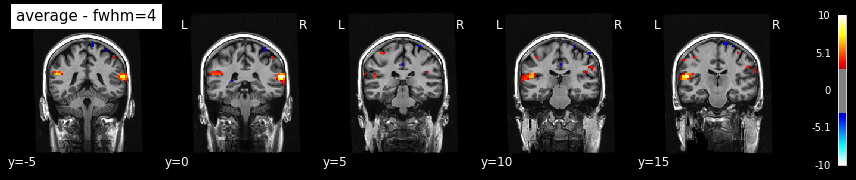

In [22]:
plot_stat_map(
    '//home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

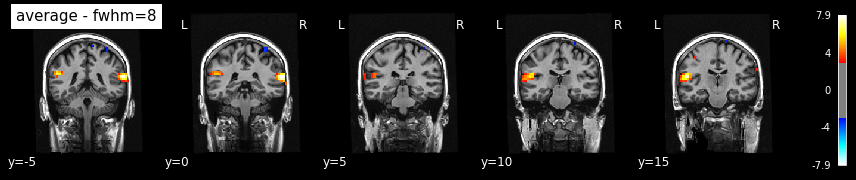

In [23]:
plot_stat_map(
    '//home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

Now, let's look at the three contrasts **`Finger`**, **`Foot`**, **`Lips`**.

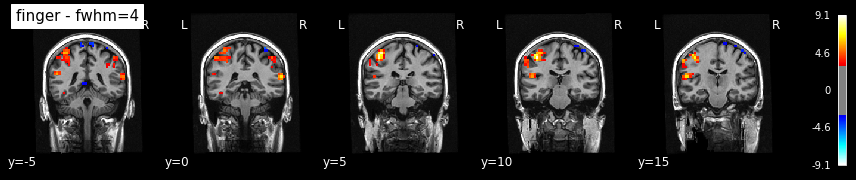

In [24]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

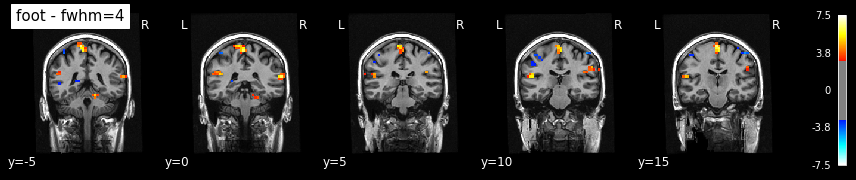

In [25]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0003.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1)

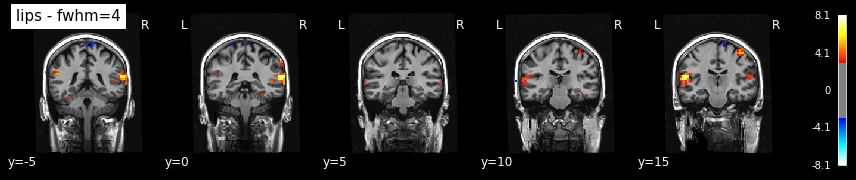

In [27]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0004.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

We can also check three additional contrasts **Finger > others**, **Foot > others** and **Lips > others**. 

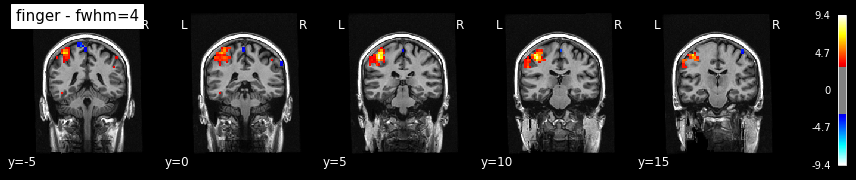

In [28]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0005.nii', title='finger - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

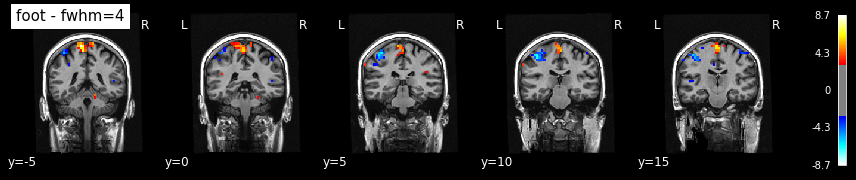

In [29]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0006.nii', title='foot - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

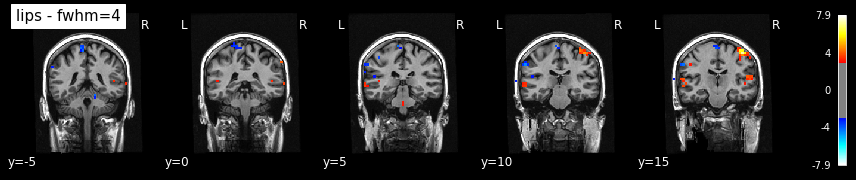

In [30]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0007.nii', title='lips - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

## Special case

There is something special with the **Finger** contrast in all subjects. So let's take a look at all of them.

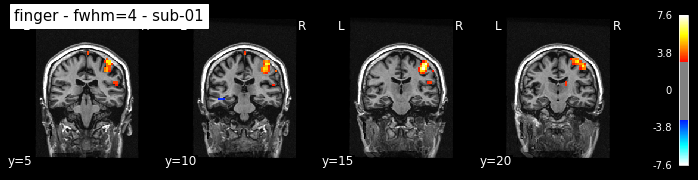

In [31]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-01/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-01',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

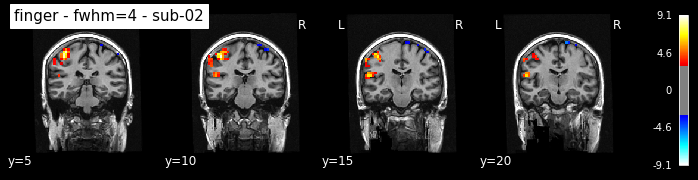

In [32]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-02/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-02',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

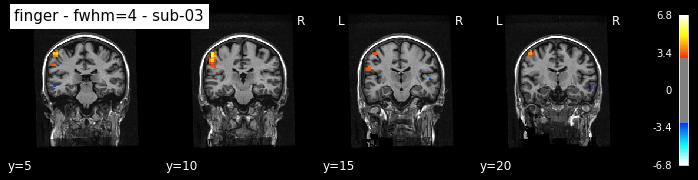

In [33]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-03/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-03',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

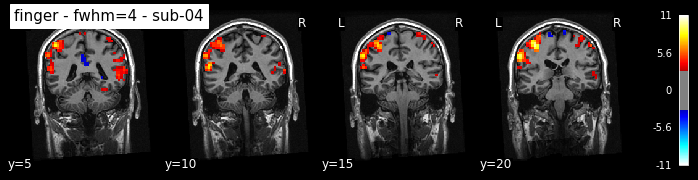

In [34]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-04/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-04',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

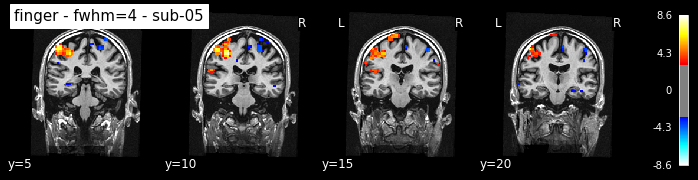

In [35]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-05/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-05',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

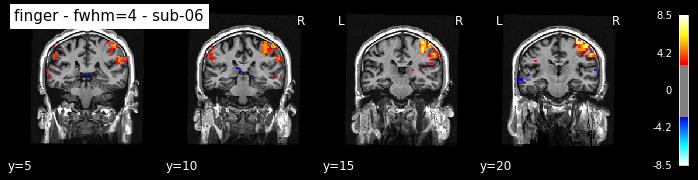

In [36]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-06/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-06',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

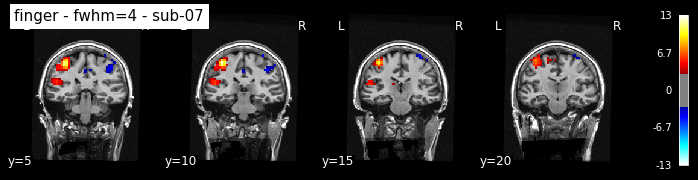

In [37]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-07/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-07',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

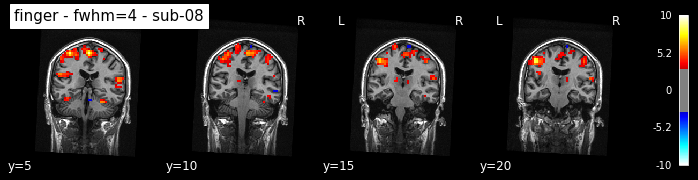

In [38]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-08/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-08',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

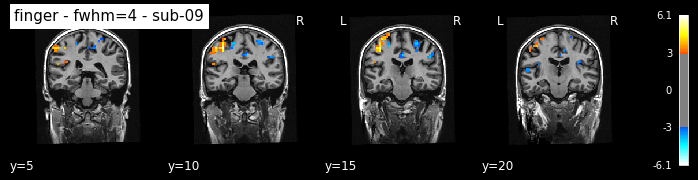

In [39]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-09/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-09',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

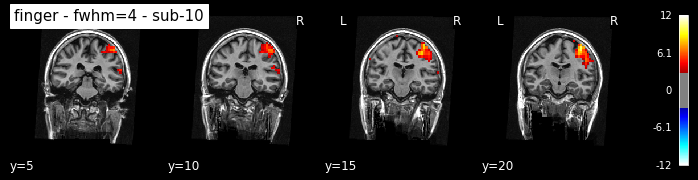

In [40]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/1stLevel/sub-10/fwhm-4/spmT_0002.nii', title='finger - fwhm=4 - sub-10',
    bg_img='/home/neuro/Data/ds000114/derivatives/fmriprep/sub-10/anat/sub-10_t1w_preproc.nii.gz',
    threshold=3, display_mode='y', cut_coords=(5, 10, 15, 20), dim=-1);

What you might see is that the hemisphere of the main cluster differs significantly between subjects. This is because all subjects were asked to use the dominant hand, either right or left. There were three subjects (``sub-01``, ``sub-06`` and ``sub-10``) that were left-handed. This can be seen in the pictures above, where we find the main cluster in the left hemisphere for right-handed subject and on the right hemisphere for left-handed subjects.

**Because of this, We will use only right-handed subjects for the following anlysis**.